<a href="https://colab.research.google.com/github/MGentieu/Data_analytics_aircraft_messages/blob/main/GENTIEU_Martin_TP1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# GENTIEU Martin : TP de data analytics

###On se place dans un premier temps dans le répertoire parent

In [8]:
import os
import sys
from pathlib import Path

# Detect working directory
cwd = Path.cwd().resolve()

# If in Colab (/content), search for repo folder automatically
if cwd.name == "content":
    # Look for the cloned project automatically
    candidates = [d for d in cwd.iterdir() if d.is_dir() and "aircraft" in d.name.lower()]

    if not candidates:
        raise FileNotFoundError(
            f"Aucun dossier contenant 'aircraft' trouvé dans /content.\n"
            f"Dossiers présents : {os.listdir(cwd)}"
        )

    PROJECT_ROOT = candidates[0]
else:
    PROJECT_ROOT = cwd

print(f"Detected project root: {PROJECT_ROOT}")

# Validate directory
if not PROJECT_ROOT.exists():
    raise FileNotFoundError(f"Missing directory at {PROJECT_ROOT}")

# Add to Python path
if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))

print("Setup complete.")


Detected project root: /content/Data_analytics_aircraft_messages
Setup complete.


On importe ensuite les bibliothèques nécessaires à l'analyse :

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import folium
import shapely
import socket
import csv
from datetime import datetime

On exécute ensuite le script python test.py pour récupérer les messages

In [ ]:
HOST = "sbs.glidernet.org"
PORT = 30003

# Timestamp pour nommer le fichier
date = datetime.now().strftime('%Y%m%d_%H%M%S')

# Fichier CSV de sortie
output_file = f"{PROJECT_ROOT}/adsb_data_{date}.csv"

# Liste des colonnes SBS (22 champs)
cols = [
    "MessageType",
    "TransmissionType",
    "SessionID",
    "AircraftID",
    "HexIdent",
    "FlightID",
    "DateGenerated",
    "TimeGenerated",
    "DateLogged",
    "TimeLogged",
    "Callsign",
    "Altitude",
    "GroundSpeed",
    "Track",
    "Latitude",
    "Longitude",
    "VerticalRate",
    "Squawk",
    "Alert",
    "Emergency",
    "SPI",
    "IsOnGround"
]

print(f"Connexion à {HOST}:{PORT} ...")

with socket.socket(socket.AF_INET, socket.SOCK_STREAM) as s:
    s.connect((HOST, PORT))
    print("Connecté ! Réception des messages ADS-B...\n")

    # Création et ouverture du CSV
    with open(output_file, "w", newline="", encoding="utf-8") as f:
        writer = csv.writer(f, delimiter=",")
        writer.writerow(cols)  # Header complet

        try:
            for _ in range(50):  # Nombre de messages SBS à traiter
                data = s.recv(1024).decode(errors="ignore")

                for line in data.strip().split("\n"):
                    if line.startswith("MSG"):
                        fields = line.split(",")
                        # print(fields)

                        # Certain messages peuvent être plus courts → on complète
                        if len(fields) < len(cols):
                            fields += [""] * (len(cols) - len(fields))

                        writer.writerow(fields)

        except KeyboardInterrupt:
            print("\nArrêt manuel par l’utilisateur.")
        except Exception as e:
            print("Erreur :", e)

print(f"\nDonnées enregistrées dans : {output_file}")


###1.1. Chargement du fichier avec la librairie pandas

In [16]:
df = pd.read_csv(output_file)
#df = df[0].str.split(",", expand=True)

Analyse initiale du dataset :

In [17]:
df.head()

,MessageType,TransmissionType,SessionID,AircraftID,HexIdent,FlightID,DateGenerated,TimeGenerated,DateLogged,TimeLogged,...,GroundSpeed,Track,Latitude,Longitude,VerticalRate,Squawk,Alert,Emergency,SPI,IsOnGround
0,MSG,3.0,NaN,NaN,3C1459,NaN,2025/11/19,13:14:04.509,2025/11/19,13:14:04.509,...,260.0,289.0,50.09645,19.51798,NaN,NaN,0.0,0.0,0.0,0.0
1,MSG,3.0,NaN,NaN,4B1E44,NaN,2025/11/19,13:14:04.512,2025/11/19,13:14:04.512,...,125.0,207.0,46.91357,7.26475,NaN,NaN,0.0,0.0,0.0,0.0
2,MSG,3.0,NaN,NaN,5F528C,NaN,2025/11/19,13:14:04.514,2025/11/19,13:14:04.514,...,139.0,73.0,49.65708,14.00852,NaN,NaN,0.0,0.0,0.0,0.0
3,MSG,3.0,NaN,NaN,DD0569,NaN,2025/11/19,13:14:04.521,2025/11/19,13:14:04.521,...,71.0,135.0,53.78250,-2.67783,NaN,NaN,0.0,0.0,0.0,0.0
4,MSG,3.0,NaN,NaN,47887E,NaN,2025/11/19,13:14:04.523,2025/11/19,13:14:04.523,...,206.0,87.0,60.39298,6.09557,NaN,NaN,0.0,0.0,0.0,0.0


In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10771 entries, 0 to 10770
Data columns (total 22 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   MessageType       10771 non-null  object 
 1   TransmissionType  10736 non-null  float64
 2   SessionID         0 non-null      float64
 3   AircraftID        0 non-null      float64
 4   HexIdent          10685 non-null  object 
 5   FlightID          0 non-null      float64
 6   DateGenerated     10585 non-null  object 
 7   TimeGenerated     10458 non-null  object 
 8   DateLogged        10281 non-null  object 
 9   TimeLogged        10131 non-null  object 
 10  Callsign          9939 non-null   object 
 11  Altitude          9869 non-null   float64
 12  GroundSpeed       9800 non-null   float64
 13  Track             9692 non-null   float64
 14  Latitude          9582 non-null   object 
 15  Longitude         9447 non-null   object 
 16  VerticalRate      0 non-null      float6

In [19]:
df.describe()

,TransmissionType,SessionID,AircraftID,FlightID,Altitude,GroundSpeed,Track,VerticalRate,Squawk,Alert,Emergency,SPI,IsOnGround
count,10736.0,0.0,0.0,0.0,9869.000000,9800.000000,9692.000000,0.0,0.0,9324.0,9304.0,9279.0,9258.0
mean,3.0,NaN,NaN,NaN,10479.457291,207.450510,174.719563,NaN,NaN,0.0,0.0,0.0,0.0
std,0.0,NaN,NaN,NaN,10319.292360,139.554743,106.013604,NaN,NaN,0.0,0.0,0.0,0.0
min,3.0,NaN,NaN,NaN,0.000000,0.000000,0.000000,NaN,NaN,0.0,0.0,0.0,0.0
25%,3.0,NaN,NaN,NaN,2930.000000,88.000000,87.000000,NaN,NaN,0.0,0.0,0.0,0.0
50%,3.0,NaN,NaN,NaN,6854.000000,190.000000,180.500000,NaN,NaN,0.0,0.0,0.0,0.0
75%,3.0,NaN,NaN,NaN,14058.000000,323.000000,264.000000,NaN,NaN,0.0,0.0,0.0,0.0
max,3.0,NaN,NaN,NaN,43432.000000,549.000000,360.000000,NaN,NaN,0.0,0.0,0.0,0.0


###1.2. Extraction des colonnes utiles

In [22]:
df_parsed = pd.DataFrame({
    'icao': df["HexIdent"],
    'registration': df["Callsign"],
    'altitude': pd.to_numeric(df["Altitude"], errors='coerce'),
    'velocity': pd.to_numeric(df["GroundSpeed"], errors='coerce'),
    'heading': pd.to_numeric(df["Track"], errors='coerce'),
    'lat': pd.to_numeric(df["Latitude"], errors='coerce'),
    'lon': pd.to_numeric(df["Longitude"], errors='coerce'),
    'timestamp' : df["DateGenerated"] + " " + df["TimeGenerated"]
})

df_parsed["timestamp"] = pd.to_datetime(df_parsed["timestamp"], errors='coerce')

df_parsed.describe()

,altitude,velocity,heading,lat,lon,timestamp
count,9869.000000,9800.000000,9692.000000,9581.000000,9446.000000,10356
mean,10479.457291,207.450510,174.719563,47.077130,6.387338,2025-11-19 13:14:37.663784192
min,0.000000,0.000000,0.000000,-34.426550,-112.160680,2025-11-19 13:14:04
25%,2930.000000,88.000000,87.000000,45.262580,1.871132,2025-11-19 13:14:12.334749952
50%,6854.000000,190.000000,180.500000,48.656630,8.197545,2025-11-19 13:14:37.339500032
75%,14058.000000,323.000000,264.000000,51.299500,11.319495,2025-11-19 13:14:58.922249984
max,43432.000000,549.000000,360.000000,69.864420,151.514680,2025-11-19 13:15:54.335000
std,10319.292360,139.554743,106.013604,10.188924,12.678558,NaN


In [23]:
df_parsed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10771 entries, 0 to 10770
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   icao          10685 non-null  object        
 1   registration  9939 non-null   object        
 2   altitude      9869 non-null   float64       
 3   velocity      9800 non-null   float64       
 4   heading       9692 non-null   float64       
 5   lat           9581 non-null   float64       
 6   lon           9446 non-null   float64       
 7   timestamp     10356 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(5), object(2)
memory usage: 673.3+ KB


In [24]:
df_parsed.head()

,icao,registration,altitude,velocity,heading,lat,lon,timestamp
0,3C1459,ICA3C1459,8365.0,260.0,289.0,50.09645,19.51798,2025-11-19 13:14:04.509
1,4B1E44,ICA4B1E44,8764.0,125.0,207.0,46.91357,7.26475,2025-11-19 13:14:04.512
2,5F528C,FLR5F528C,4039.0,139.0,73.0,49.65708,14.00852,2025-11-19 13:14:04.514
3,DD0569,FLRDD0569,597.0,71.0,135.0,53.78250,-2.67783,2025-11-19 13:14:04.521
4,47887E,ICA47887E,15825.0,206.0,87.0,60.39298,6.09557,2025-11-19 13:14:04.523


In [26]:
icao_sample = df_parsed['icao'].value_counts().index[0]
flight = df_parsed[df_parsed['icao'] == icao_sample].sort_values('timestamp')
flight.head(15)

,icao,registration,altitude,velocity,heading,lat,lon,timestamp
73,4B1E45,ICA4B1E45,7711.0,92.0,208.0,48.25403,7.74967,2025-11-19 13:14:04.683
188,4B1E45,ICA4B1E45,7734.0,92.0,208.0,48.00000,NaN,2025-11-19 13:14:05.283
238,4B1E45,ICA4B1E45,7711.0,92.0,208.0,48.25403,7.74967,2025-11-19 13:14:05.378
282,4B1E45,ICA4B1E45,7734.0,92.0,208.0,48.25367,7.74937,2025-11-19 13:14:05.437
284,4B1E45,ICA4B1E45,7734.0,92.0,208.0,48.25367,7.74937,2025-11-19 13:14:05.440
333,4B1E45,ICA4B1E45,7734.0,92.0,208.0,48.25367,7.74937,2025-11-19 13:14:05.515
518,4B1E45,ICA4B1E45,7734.0,92.0,208.0,48.25367,7.74937,2025-11-19 13:14:05.903
619,4B1E45,ICA4B1E45,7734.0,92.0,208.0,48.25367,7.74937,2025-11-19 13:14:06.084
625,4B1E45,ICA4B1E45,7734.0,92.0,208.0,48.25367,7.74937,2025-11-19 13:14:06.092
761,4B1E45,ICA4B1E45,7754.0,92.0,209.0,48.25328,7.74905,2025-11-19 13:14:06.304


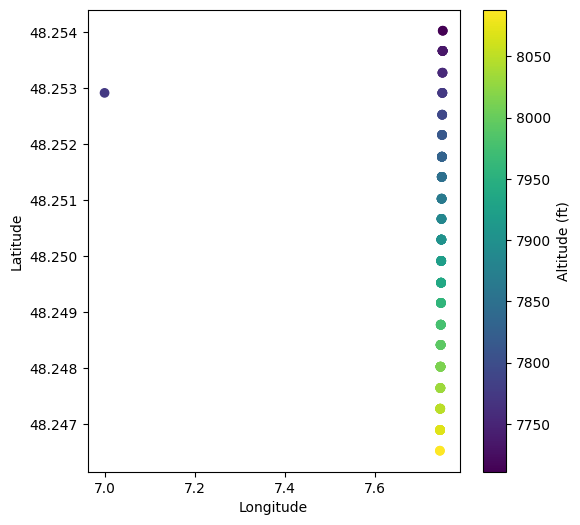

In [28]:
plt.figure(figsize=(6,6))
plt.scatter(flight['lon'], flight['lat'], c=flight['altitude'], cmap='viridis')
plt.colorbar(label='Altitude (ft)')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()